In [6]:
!pip install torch torchvision


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Positional Encoding (for attention-based models)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer-based Generator (simplified)
class TransformerGenerator(nn.Module):
    def __init__(self, noise_dim, img_size):
        super().__init__()
        self.linear = nn.Linear(noise_dim, 256)
        self.pos_enc = PositionalEncoding(d_model=256, max_len=16)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512, batch_first=True)

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc = nn.Linear(256, img_size * img_size)
        self.img_size = img_size

    def forward(self, z):
        x = self.linear(z).unsqueeze(1)  # (B, 1, 256)
        x = self.pos_enc(x)
        x = self.transformer(x)
        x = self.fc(x[:, 0])  # Only first token used for simplicity
        img = x.view(-1, 1, self.img_size, self.img_size)
        return torch.tanh(img)

# Simple CNN Discriminator
class CNNDiscriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # (B, 64, H/2, W/2)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear((img_size // 4) * (img_size // 4) * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Test run
noise_dim = 100
img_size = 28

G = TransformerGenerator(noise_dim=noise_dim, img_size=img_size)
D = CNNDiscriminator(img_size=img_size)

z = torch.randn(8, noise_dim)
fake_images = G(z)
output = D(fake_images)

print("Generated image shape:", fake_images.shape)
print("Discriminator output:", output.squeeze())

Generated image shape: torch.Size([8, 1, 28, 28])
Discriminator output: tensor([0.4940, 0.5072, 0.5031, 0.5191, 0.5057, 0.5186, 0.5156, 0.5079],
       grad_fn=<SqueezeBackward0>)


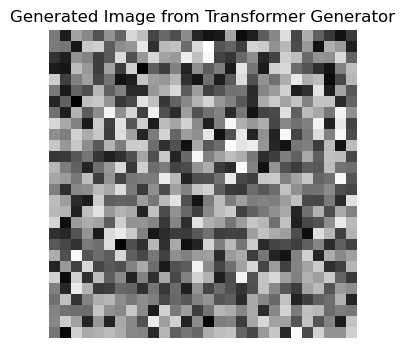

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G.eval()
with torch.no_grad():
    noise = torch.randn(1, 100).to(device)
    fake_image = G(noise).cpu().squeeze().numpy()

plt.figure(figsize=(4, 4))
plt.imshow(fake_image, cmap='gray')
plt.title("Generated Image from Transformer Generator")
plt.axis('off')
plt.show()
